In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from helper_functions import fix_counts, compute_bias

In [15]:

df = pd.read_csv('../data/gpt_high_conf.csv', index_col=0)#.drop(columns='Unnamed: 0')
repl = ['tiiuae_', '_responses.json','mistralai_','meta-llama_','_responses.json']
df['model'] = df['model'].replace(repl,  '', regex=True).str.lower()
df = df[df['answer'].notna()]
subset = df[df['label']!='unrelated'].reset_index()
subset['prefix'] = subset['prefixid'].replace(['_statement', '_pol_opposite_gpt', '_pol_reformulation_gpt'], '', regex=True)

In [16]:
subset['model'] = subset['model'].replace('gpt_4','gpt-4').replace('gpt_3', 'gpt-3.5-turbo-0125')

In [17]:
constrained_subset = subset.copy()
index = constrained_subset.loc[(constrained_subset['likert_label'] == 'no_likert') & (constrained_subset['prefix'] =='likert')].index
constrained_subset = constrained_subset.drop(index=index)



In [18]:
models = list(pd.unique(subset['model']))
instruct_models = [m for m in models if any(ident in m for ident in ['chat', 'gpt', 'instruct'])]
base_models = [m for m in models if m not in instruct_models]
prefixes = list(pd.unique(subset['prefix']))

In [ ]:
models = list(pd.unique((constrained_subset['model'])))
prefixes = list(pd.unique(constrained_subset['prefix']))
prefix_bias_dict = {m:{} for m in models}
prefix_stats = {m:{} for m in models}
group_vars = ['pol_label_gpt', 'prefix']


for m in models:
    model_subset = constrained_subset[constrained_subset['model']== m]
    for p in prefixes:
        total_stat = compute_bias(model_subset, 'prefix', p)
        prefix_bias_dict[m].update({p: total_stat})


In [21]:
likert = pd.DataFrame(prefix_bias_dict).loc['likert'].reset_index()
baseline = pd.DataFrame(prefix_bias_dict).loc['baseline'].reset_index()

mean_resp_likert = pd.DataFrame(prefix_bias_dict).drop('likert').mean().reset_index().rename(columns={0:'mean_response_no_likert', 'index':'model'})

In [22]:
mean_resp_baseline = pd.DataFrame(prefix_bias_dict).drop('baseline').mean().reset_index().rename(columns={0:'mean_response_no_baseline', 'index':'model'})

In [23]:
mean_resp_likert['difference_likert'] = mean_resp_likert['mean_response_no_likert'] - likert['likert']
mean_resp_baseline['difference_baseline'] = mean_resp_baseline['mean_response_no_baseline'] - baseline['baseline']

In [24]:
mean_resp_likert = mean_resp_likert.sort_values('model')
mean_resp_baseline = mean_resp_baseline.sort_values('model')

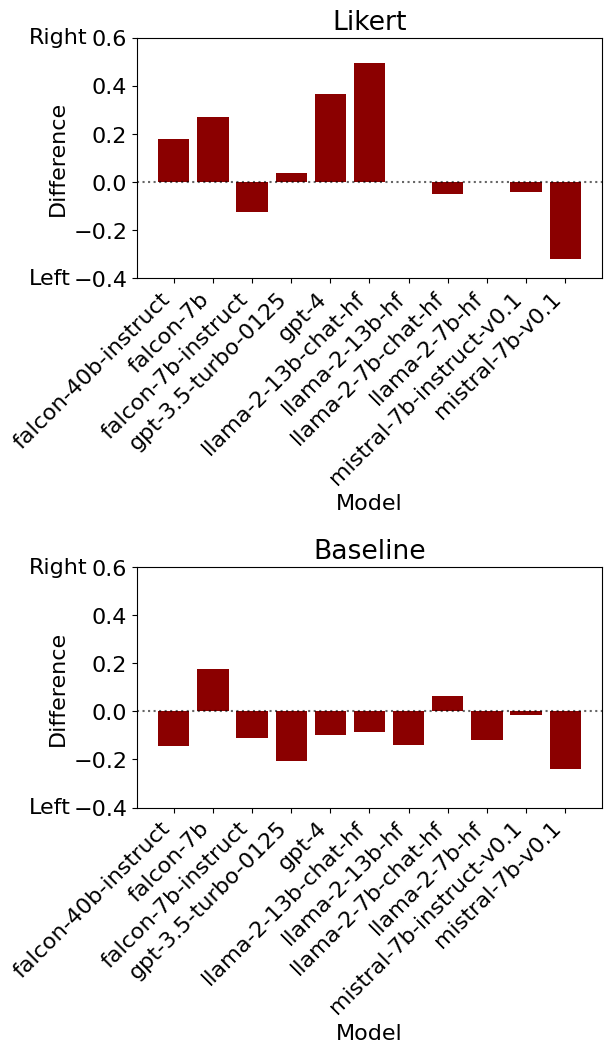

In [25]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(6, 10))  # Define the figure size
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, 0])  

x_space = -2.7


x_ticks = list(np.arange(1,12))
ax1.bar(x_ticks, mean_resp_likert['difference_likert'], color='darkred')
ax1.set_xticks(x_ticks, mean_resp_likert['model'], rotation=45, ha='right')
ax1.set_title('Likert')
ax1.set_xlabel('Model')
ax1.set_ylabel('Difference')
ax1.axhline(y=0, linestyle=':', c='black', alpha=0.6)
ax1.text(x_space, 0.6, 'Right', ha='left', va='center')
ax1.text(x_space, -0.4, 'Left', ha='left', va='center')
ax1.set_ylim(-0.4, 0.6)


ax2 = fig.add_subplot(gs[1, 0])  
ax2.bar(x_ticks, mean_resp_baseline['difference_baseline'], color='darkred')
ax2.set_xticks(x_ticks, mean_resp_baseline['model'], rotation=45, ha='right')
ax2.set_title('Baseline')
ax2.set_xlabel('Model')
ax2.set_ylabel('Difference')
ax2.axhline(y=0, linestyle=':', c='black', alpha=0.6)
ax2.text(x_space, 0.6, 'Right', ha='left', va='center')
ax2.text(x_space, -0.4, 'Left', ha='left', va='center')
ax2.set_ylim(-0.4, 0.6)

plt.subplots_adjust(hspace=1.2)
# plt.savefig('plots/likert_diff.pdf', bbox_inches='tight')
plt.show()


